# Train

In [3]:
%load_ext autoreload
%autoreload 

In [19]:
import torch
import numpy as np
import xarray as xr
from pathlib import Path
import os
import random

import dask
from torch import nn

from hython.preprocess import apply_normalization
from hython.datasets.datasets import LSTMDataset
from hython.train_val import train_val
from hython.sampler import RegularIntervalSampler, DataLoaderSpatialSampler
from hython.metrics import mse_metric
from hython.losses import RMSELoss
from hython.utils import read_from_zarr, missing_location_idx, get_sampler_config, set_seed
from hython.models.cudnnLSTM import CuDNNLSTM
from hython.trainer import RNNTrainer, RNNTrainParams

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset

# viz
import matplotlib.pyplot as plt
from hython.viz import plot_sampler

# Settings

In [27]:
WFLOW_MODEL =  "alps1km_eobs"
SURROGATE_MODEL = "alps1km_eobs"
EXP = "s000100"
SEED = 1696

dynamic_names = ["precip", "pet", "temp"] 
static_names = [ 'thetaS', 'thetaR', 'RootingDepth', 'Swood','KsatVer', "Sl"] 
target_names = [ "vwc","actevap"] 

# DL model hyper parameters
HIDDEN_SIZE = 24
INPUT_SIZE = len(dynamic_names)
OUTPUT_SIZE = len(target_names)
NUMBER_STATIC_PREDICTORS = len(static_names)
TARGET_WEIGHTS = {t:0.5 for t in target_names}

# train/val parameters

train_start = "2016-01-01"
train_end = "2016-12-31"
train_range = slice(train_start,train_end)

EPOCHS = 20
SPATIAL_BATCH_SIZE = 256
TEMPORAL_SAMPLING_SIZE = 150 
SEQ_LENGTH = 360 

# sampler parameters

INTERVALS = [10, 10] # km
TRAIN_ORIGIN = [0, 0]
VAL_ORIGIN = [5, 5]

# missing policy
remove_lakes = True

assert sum(v for v in TARGET_WEIGHTS.values()) == 1, "check target weights"
TARGET_INITIALS = "".join([i[0].capitalize() for i in target_names])

# paths
WD =  Path("/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/")
SURR_INPUT = WD / "surrogate_training" / f"{WFLOW_MODEL}.zarr"
SURR_MODEL_WEIGHTS = WD / "surrogate_model" / f"{SURROGATE_MODEL}_{EXP}_v{TARGET_INITIALS}_h{HIDDEN_SIZE}_s{SEED}.pt"
SURR_MODEL_WEIGHTS

PosixPath('/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/alps1km_eobs_s000100_vVA_h24_s1696.pt')

In [28]:
set_seed(SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
# Read from preprocessed data, select train range

# train
Xd = read_from_zarr(url=SURR_INPUT, group="xd", multi_index="gridcell").sel(time = train_range).xd
Xs = read_from_zarr(url=SURR_INPUT, group="xs", multi_index="gridcell").xs
Y = read_from_zarr(url=SURR_INPUT, group="y", multi_index="gridcell").sel(time = train_range).y

# other 
# wflow_lakes = Xs.sel(feat="wflow_lakeareas").unstack()
#wflow_dem = Xs.sel(feat="wflow_dem").unstack()

# select features and targets 
Xd = Xd.sel(feat=dynamic_names)
Xs = Xs.sel(feat=static_names)
Y = Y.sel(feat=target_names)

print(Xd.shape, Xs.shape, Y.shape)
# read masks
mask_missing = read_from_zarr(url=SURR_INPUT, group="mask" ).mask

(810953, 366, 3) (810953, 6) (810953, 366, 2)


In [10]:
# Define the spatial samplers for both training and validation sets. Remeber the subsets should not overlap, so choose different origins.

# training set
spatial_train_sampler = RegularIntervalSampler(intervals = INTERVALS, origin = TRAIN_ORIGIN)

# validation set
spatial_val_sampler = RegularIntervalSampler(intervals = INTERVALS, origin = VAL_ORIGIN) 

# Apply the samplers: return the cell indices that can be used later in training and validation to sample the whole spatial domain.
data2d  = mask_missing.values

idx = missing_location_idx(Xs.values)

sampler_train_meta = spatial_train_sampler.sampling_idx(data2d, mask_missing)
sampler_val_meta = spatial_val_sampler.sampling_idx(data2d, mask_missing)

# some useful metadata
print(sampler_train_meta)

# check location of training and validation sets
#_ = plot_sampler(mask_missing, sampler_train_meta, sampler_val_meta, figsize= (8, 8 ), markersize = 2)


SamplerResult(
 - id_grid_2d: (689, 1177) 
 - idx_sampled_1d: (51035,) 
 - idx_sampled_1d_nomissing: (23740,)) 
 - idx_missing_1d: (431441,) 
 - sampled_grid_dims: (173, 295) 
 - xr_coords: None


In [11]:
print("Percentage of sampled data: ",(len(sampler_train_meta.idx_sampled_1d_nomissing)/ len(Xs[~idx].values.flatten()))*100, "%")

Percentage of sampled data:  1.0425669456213946 %


In [12]:
# # Normalizing

# statistics from training set
_, d_m, d_std = apply_normalization(Xd[sampler_train_meta.idx_sampled_1d_nomissing], type = "spacetime", how ='standard')
_, s_m, s_std = apply_normalization(Xs[sampler_train_meta.idx_sampled_1d_nomissing], type = "space", how ='standard')
_, y_m, y_std = apply_normalization(Y[sampler_train_meta.idx_sampled_1d_nomissing], type = "spacetime", how ='standard')

# normalize training set and validation set
Xd = apply_normalization(Xd, type="spacetime", how="standard", m1 = d_m, m2 = d_std).compute()
Xs = apply_normalization(Xs, type="space", how="standard",  m1 = s_m, m2 = s_std).compute()
Y = apply_normalization(Y, type="spacetime",how="standard", m1 = y_m, m2 = y_std).compute()

# Prepare Model inputs

In [13]:
Xs = torch.Tensor(Xs.values)
Xd = torch.Tensor(Xd.values)
Y = torch.Tensor(Y.values)

print(Xs.shape, Xd.shape, Y.shape)

# init datasets
dataset = LSTMDataset(Xd, Y, Xs)

train_sampler = DataLoaderSpatialSampler(dataset, num_samples=1, sampling_indices = sampler_train_meta.idx_sampled_1d_nomissing.tolist())
valid_sampler = DataLoaderSpatialSampler(dataset, num_samples=1, sampling_indices = sampler_val_meta.idx_sampled_1d_nomissing.tolist())

train_loader = DataLoader(dataset, batch_size=SPATIAL_BATCH_SIZE, shuffle=False, sampler = train_sampler) # implement shuffling in the sampler!
val_loader = DataLoader(dataset, batch_size=SPATIAL_BATCH_SIZE, shuffle=False, sampler = valid_sampler)


torch.Size([810953, 6]) torch.Size([810953, 366, 3]) torch.Size([810953, 366, 2])


# Initialize Model

In [29]:
model = CuDNNLSTM(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, NUMBER_STATIC_PREDICTORS)
model = model.to(device)
model

CuDNNLSTM(
  (fc0): Linear(in_features=9, out_features=24, bias=True)
  (lstm): LSTM(24, 24, batch_first=True)
  (fc1): Linear(in_features=24, out_features=2, bias=True)
)

# Train/valid settings

In [30]:
opt = optim.Adam(model.parameters(), lr=1e-3)


loss_fn = RMSELoss(target_weight=TARGET_WEIGHTS)


metric_fn = mse_metric

lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=10)


In [31]:
params_train={
    "experiment":EXP,
    "subsample": True,
    "n_subsample": TEMPORAL_SAMPLING_SIZE,
    "seq_length": SEQ_LENGTH,
    "time_range": Y.shape[1],
    "loss_func": loss_fn,
    "metric_func": metric_fn,
    "train_dataloader": train_loader, 
    "val_dataloader": val_loader,
    "target_names": target_names
}

In [32]:
trainer = RNNTrainer(params_train)

# Run Train/valid

In [33]:
model, loss_history, metric_history = train_val(trainer, model, EPOCHS, opt, lr_scheduler, SURR_MODEL_WEIGHTS, device)

  0%|                                                                                                         | 0/20 [02:22<?, ?it/s]


RuntimeError: File /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/alps1km_eobs_s000100_vVA_h24_s1696.pt cannot be opened.

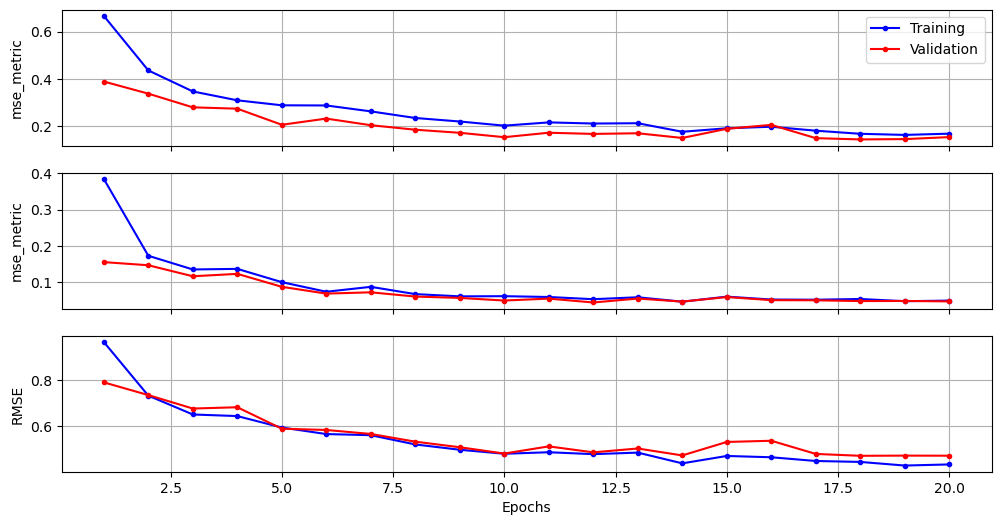

In [14]:
lepochs = list(range(1,params_train["num_epochs"] + 1))

fig, axs = plt.subplots(3, 1, figsize= (12,6), sharex=True)

axs[0].plot(lepochs, sm_metric_history['train_vwc'], marker='.', linestyle='-', color='b', label='Training')
axs[0].plot(lepochs, sm_metric_history['val_vwc'], marker='.', linestyle='-', color='r', label='Validation')
#axs[0].title('Validation Loss - SM')
axs[0].set_ylabel(metric_fn.__name__)
axs[0].grid(True)
axs[0].legend(bbox_to_anchor=(1,1))

axs[1].plot(lepochs, sm_metric_history['train_actevap'], marker='.', linestyle='-', color='b', label='Training')
axs[1].plot(lepochs, sm_metric_history['val_actevap'], marker='.', linestyle='-', color='r', label='Validation')
#axs[0].title('Validation Loss - SM')
axs[1].set_ylabel(metric_fn.__name__)
axs[1].grid(True)

axs[2].plot(lepochs, [i.detach().cpu().numpy() for i in sm_loss_history['train']], marker='.', linestyle='-', color='b', label='Training')
axs[2].plot(lepochs, [i.detach().cpu().numpy() for i in sm_loss_history['val']], marker='.', linestyle='-', color='r', label='Validation')
#axs[0].title('Validation Loss - SM')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel(loss_fn.__name__)
axs[2].grid(True)

In [15]:
# save model
torch.save(model.state_dict(), SURR_MODEL_WEIGHTS)